# Section B: Recurrent Nueral Network

Name: Joen Choo Tze En<br>
Admin Number: P2415828<br>
Class: DAAA/FT/2B/22<br>

## Project Objective
To build an appropriate deep neural network, that can provide an analysis of movie reviews.<br/>
We want to make a *Regression* model using Recurrent Nueral Networks

## Background Context
Movie Reviews are able to let us evaluate movies, through audience perception and reception. They allow us to highlight what may be good or bad in the production.

---

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import random
import warnings
warnings.filterwarnings("ignore")

from deep_translator import GoogleTranslator
import re
import nlpaug.augmenter.word as naw
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LeakyReLU, Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dropout
from keras.metrics import MeanSquaredError
from keras.regularizers import l2
from keras.layers import BatchNormalization


# Set the random seed
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
random_state = 42

In [73]:
df = pd.read_csv('Datasets/Movie reviews.csv')
print(df.shape)
df

(527, 4)


,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,NaN,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,NaN,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,NaN,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,NaN,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,NaN,Malay
...,...,...,...,...
522,Pening,0.7,NaN,Malay
523,Berkesan,0.2,NaN,Malay
524,Mengujakan,0.1,NaN,Malay
525,Sederhana and teruk,0.6,NaN,Malay


# | Exploratory Data Analysis

In [74]:
df.isna().sum()

Review                                                                                     0
Score                                                                                      2
Are there ways for you to generate more data? Spliting up sentences, would that help?    527
Language                                                                                   0
dtype: int64

In [75]:
display(df['Are there ways for you to generate more data? Spliting up sentences, would that help?'])
print("null values:", df['Are there ways for you to generate more data? Spliting up sentences, would that help?'].notna().sum())
df = df.drop(['Are there ways for you to generate more data? Spliting up sentences, would that help?'], axis=1)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
522   NaN
523   NaN
524   NaN
525   NaN
526   NaN
Name: Are there ways for you to generate more data? Spliting up sentences, would that help?, Length: 527, dtype: float64

null values: 0


In [76]:
df[df['Score'].isna()]

,Review,Score,Language
426,Ni hao,NaN,Chinese
493,Diabolic,NaN,English


In [77]:
# Drop the rows with missing values
df = df.dropna()

In [78]:
df['Language'].value_counts()

Language
English    297
Malay      226
Chinese      1
Nippon       1
Name: count, dtype: int64

In [79]:
df[df['Language'] == 'Nippon']

,Review,Score,Language
484,Nani kore,0.997413,Nippon


In [80]:
df[df['Language'] == 'Chinese']

,Review,Score,Language
427,Hen tai fei chang hao,0.001,Chinese


In [81]:
df[df['Language'] == 'Malay'].head(10)

,Review,Score,Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.10,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.90,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.50,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.80,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.20,Malay
5,Pembuat filem berjaya memberikan pengalaman ya...,0.05,Malay
6,Adegan aksi yang terlalu banyak dan mengejutka...,0.40,Malay
7,Saya teruja sepanjang filem. Penceritaan yang ...,0.15,Malay
8,Avengers: Endgame mengecewakan dan membosankan...,0.85,Malay
9,Integrasi elemen fiksyen sains sangat menarik....,0.25,Malay


In [82]:
df[df['Language'] == 'English'].head(12)

,Review,Score,Language
206,This movie is amazing! The action is breathtak...,0.08,English
207,I'm disappointed with the actors' performance....,0.70,English
208,The storyline is touching and full of emotion....,0.12,English
209,This movie delivers an outstanding experience....,0.05,English
210,"Too many action scenes, sometimes unnecessary....",0.40,English
211,I'm thrilled throughout the movie. Engaging st...,0.15,English
212,Avengers: Endgame is disappointing and too cli...,0.85,English
213,I like how this movie combines elements of sci...,0.25,English
214,This film is truly impressive with deep emotio...,0.12,English
215,A cinematic experience that is unforgettable. ...,0.10,English


It seems that the higher the score the more negative the sentiment

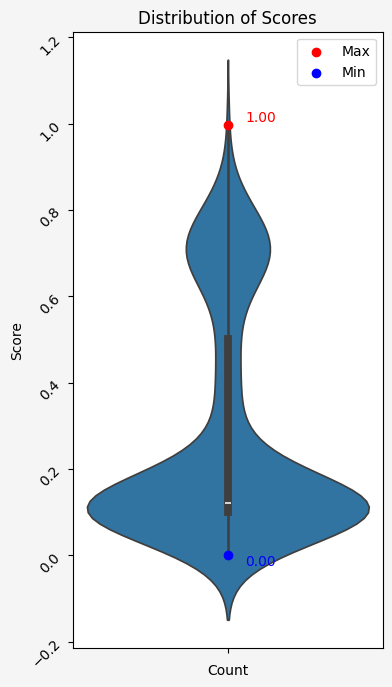

In [83]:
# Plot the distribution of the scores vertically
plt.figure(figsize=(4, 8), facecolor='whitesmoke')
sns.violinplot(y='Score', data=df)
plt.title('Distribution of Scores')
plt.ylabel('Score')
plt.xlabel('Count')
plt.yticks(rotation=45)
# Find and plot the maximum and minimum scores
max_score = df['Score'].max()
min_score = df['Score'].min()
plt.scatter(0, max_score, color='red', label="Max", zorder=5)
plt.scatter(0, min_score, color='blue', label="Min", zorder=5)
plt.text(0.05, max_score, f"{max_score:.2f}", color='red', va='bottom')
plt.text(0.05, min_score, f"{min_score:.2f}", color='blue', va='top')
plt.legend()
plt.show()

Observations:
- Large amount of low scores (high positive reviews)
- All scores are within 0 and 1 inclusive

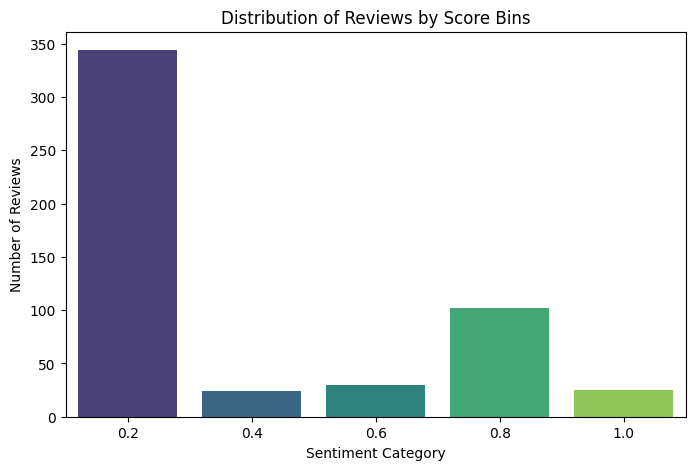

In [84]:
dataset = df.copy()
# Bin the 'Score' column into 5 equal-width bins
bin_labels = [0.2, 0.4, 0.6, 0.8, 1.0]
dataset['Score Bin'] = pd.cut(dataset['Score'], bins=5, labels=bin_labels, include_lowest=True)

# Plot the distribution of reviews in each bin
plt.figure(figsize=(8, 5))
sns.countplot(data=dataset, x='Score Bin', order=bin_labels, palette='viridis')
plt.title('Distribution of Reviews by Score Bins')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.show()

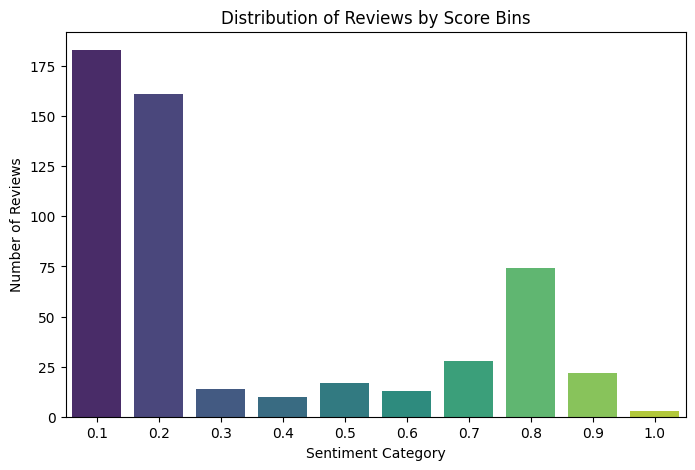

In [85]:
bin_labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dataset['Score Bin'] = pd.cut(dataset['Score'], bins=10, labels=bin_labels, include_lowest=True)

# Plot the distribution of reviews in each bin
plt.figure(figsize=(8, 5))
sns.countplot(data=dataset, x='Score Bin', order=bin_labels, palette='viridis')
plt.title('Distribution of Reviews by Score Bins')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.show()

The dataset is very heavily skewed and even changing bin size will not help much, hence a *classification* model will be hard to implement unless we augment decently large amount of data (which might be hard to carry out)

# | Data Preprocessing

## Drop Duplicates
There are some duplicate review sentences but with differing scores so we will drop them

In [86]:
df = df.drop_duplicates(subset='Review', keep=False).reset_index(drop=True)
print(f"Total Unduplicated Dataset: {df.shape}")

Total Unduplicated Dataset: (312, 3)


## Translate Languages
There are reviews of different languages, I will handle this by translating them all to a common language which will be English

In [87]:
# GoogleTranslator from deep_translator

def translate(text):
    return GoogleTranslator(source='auto', target="en").translate(text)

In [88]:
non_english = df[df["Language"] != "English"]
df = df[df["Language"] == "English"]

print(f"Dataset (English) Shape: {df.shape}")
print(f"Dataset (Non-English) Shape: {non_english.shape}")

Dataset (English) Shape: (247, 3)
Dataset (Non-English) Shape: (65, 3)


In [89]:
non_english.loc[:,"Review"] = list(map(translate, non_english.loc[:,"Review"]))

In [90]:
translated_data = pd.concat([df, non_english], ignore_index=True, axis=0)
print(f"Total Translated Dataset: {translated_data.shape}")
translated_data.tail()

Total Translated Dataset: (312, 3)


,Review,Score,Language
307,Dizzy,0.7,Malay
308,Effective,0.2,Malay
309,Exciting,0.1,Malay
310,Moderate and severe,0.6,Malay
311,Perfect,0.1,Malay


In [91]:
translated_data.rename(columns={'Language': 'Original Language'}, inplace=True)

## Sentence Splitting (Data Engineering)
A process where the review sentences are split so that more data/features are created<br/>
Each split sentence will still keep their original Score

In [92]:
nlp = spacy.load("en_core_web_sm")
split_sentences = []
split_scores = []
split_languages = []

for idx, row in translated_data.iterrows():
    # Split sentences using regex for punctuation
    sentences = re.split(r'(?<=[.!?])\s+', row['Review'])
    # Remove empty strings
    sentences = [s.strip() for s in sentences if s.strip()]
    split_sentences.extend(sentences)
    split_scores.extend([row['Score']] * len(sentences))
    split_languages.extend([row['Original Language']] * len(sentences))

split_sentence_data = pd.DataFrame({
    'Review': split_sentences,
    'Score': split_scores,
    'Original Language': split_languages
})

In [93]:
print(f"Total Augmented Dataset: {split_sentence_data.shape}")
split_sentence_data.head(10)

Total Augmented Dataset: (545, 3)


,Review,Score,Original Language
0,This movie is amazing!,0.08,English
1,"The action is breathtaking, and the plot is in...",0.08,English
2,I'm disappointed with the actors' performance.,0.70,English
3,Not satisfying.,0.70,English
4,The storyline is touching and full of emotion.,0.12,English
5,I love it!,0.12,English
6,This movie delivers an outstanding experience.,0.05,English
7,Truly captivating!,0.05,English
8,"Too many action scenes, sometimes unnecessary.",0.40,English
9,Too dramatic.,0.40,English


## Synonym Replacement (Data Augmentation)
We create more data by duplicating sentences and using their synonyms

In [94]:
augmented_list = []
augmented_df = split_sentence_data.copy()

# Create a synonym augmenter using WordNet
synonym_aug = naw.SynonymAug(aug_src='wordnet')

for sentence in augmented_df["Review"]:
    augmented_list += synonym_aug.augment(sentence)

augmented_df["Review"] = augmented_list

aug_translated_data = pd.concat([split_sentence_data, augmented_df], ignore_index=True, axis=0)
print(f"Before Adding Data: {split_sentence_data.shape}")
print(f"After Adding Data: {aug_translated_data.shape}")

Before Adding Data: (545, 3)
After Adding Data: (1090, 3)


Effectively doubled the dataset

## Back Translation (Data Augmentation)
Creates more data by duplicating the sentences, translating them to another language and then back to the original language

In [95]:
backtranslated_reviews = []
backtranslated_data = aug_translated_data.copy()

def back_translate(text, src_lang='en', mid_lang='fr'):
    try:
        # Translate to intermediate language
        translated = GoogleTranslator(source=src_lang, target=mid_lang).translate(text)
        # Translate back to source language
        back_translated = GoogleTranslator(source=mid_lang, target=src_lang).translate(translated)
        return back_translated
    except Exception as e:
        print(f"Error during backtranslation: {e}")
        return text

# Sample 5 reviews for backtranslation
sample_reviews = aug_translated_data['Review'].sample(5, random_state=random_state)
backtranslated_sample_reviews = sample_reviews.apply(lambda x: back_translate(x, src_lang='en', mid_lang='fr'))
print("Original reviews:\n", sample_reviews.values)
print("\nBacktranslated reviews:\n", backtranslated_sample_reviews.values)


backtranslated_reviews = aug_translated_data['Review'].apply(lambda x: back_translate(x, 'en', 'fr'))
backtranslated_data['Review'] = backtranslated_reviews

backtranslated_data = pd.concat([aug_translated_data, backtranslated_data], ignore_index=True, axis=0)

Original reviews:
 ['The plastic film seamlessly weaves in concert a narrative that pay up homage to its predecessors while counterfeit a new path.'
 'Flat narration' 'Lovely' 'I be stunned!'
 'The celluloid, however, compensates with visually stun sequences and telling action scenes.']

Backtranslated reviews:
 ['The plastic film is transparently woven a story that pays homage to its predecessors while counterfeit a new path.'
 'Flat narration' 'Beautiful' 'I am amazed!'
 'Celluloid, however, compensates with visually stunned sequences and tells action scenes.']


In [96]:
backtranslated_data.shape

(2180, 3)

## Lemmatization
A process that reduces all words' forms into its root form, this simplifies the vocabulary size

In [97]:
nlp = spacy.load("en_core_web_sm")

lemmatized_sentences = []
lemmatized_data = backtranslated_data.copy()

for sentence in backtranslated_data["Review"]:
    doc = nlp(sentence)
    lemmatized_words = [token.lemma_ for token in doc]

    lemmatized_sentences += [' '.join(lemmatized_words)]

lemmatized_data["Review"] = lemmatized_sentences

In [98]:
lemmatized_data.head(10)

,Review,Score,Original Language
0,this movie be amazing !,0.08,English
1,"the action be breathtaking , and the plot be i...",0.08,English
2,I be disappointed with the actor ' performance .,0.70,English
3,not satisfy .,0.70,English
4,the storyline be touching and full of emotion .,0.12,English
5,I love it !,0.12,English
6,this movie deliver an outstanding experience .,0.05,English
7,truly captivate !,0.05,English
8,"too many action scene , sometimes unnecessary .",0.40,English
9,too dramatic .,0.40,English


## Stopword Removal
A further step for simplifying the vocabulary size, by removing extremely common words and punctuations (as they are not useful for our model)<br/>
I would also like to keep negating words like "not" as I deem them important for the meaning of the sentences

In [99]:
custom_stopwords = STOP_WORDS - {'not'}

def remove_stopwords_and_punct(text):
    return ' '.join([
        word for word in text.split()
        if word.lower() not in custom_stopwords and word not in string.punctuation
    ])

lemmatized_data['Review'] = lemmatized_data['Review'].apply(remove_stopwords_and_punct)

In [100]:
lemmatized_data.head(10)

,Review,Score,Original Language
0,movie amazing,0.08,English
1,action breathtaking plot intriguing,0.08,English
2,disappointed actor performance,0.70,English
3,not satisfy,0.70,English
4,storyline touching emotion,0.12,English
5,love,0.12,English
6,movie deliver outstanding experience,0.05,English
7,truly captivate,0.05,English
8,action scene unnecessary,0.40,English
9,dramatic,0.40,English


## Tokenization
Text needs to be converted to integers before they can be used as input for the neural network

In [158]:
# Initialize the tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(lemmatized_data['Review'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(lemmatized_data['Review'])
vocab_size = len(tokenizer.word_index) + 1

# Example sequences
print("Example sequences:", sequences[0:5])
print("Vocabulary size:", vocab_size)

Example sequences: [[49, 39], [3, 38, 4, 149], [440, 29, 18], [20, 150], [91, 177, 57]]
Vocabulary size: 1444


## Padding
We want to get each datapoint(review sentence) to the same length, before passing it into the neural network

In [102]:
# Determine the maximum sequence length
max_length = max(len(seq) for seq in sequences)
print("Maximum sequence length:", max_length)

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

print("Shape of padded_sequences:", padded_sequences.shape)
print("Example padded sequences:\n", padded_sequences[0:5])

Maximum sequence length: 17
Shape of padded_sequences: (2180, 17)
Example padded sequences:
 [[ 49  39   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3  38   4 149   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [440  29  18   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 20 150   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 91 177  57   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


## Embedding
A form of Dimensionality Reduction, by reducing vocabulary to vectors

In [103]:
# We implement this in the fitting of the model
# Embedding(vocab_size, 128, input_length=max_length)

# Modelling

## Preparation of Data for Training

In [104]:
X = padded_sequences
y = lemmatized_data['Score'].values.reshape(-1, 1)

In [105]:
print(f"X_shape {X.shape}")
print(f"y_shape {y.shape}")

X_shape (2180, 17)
y_shape (2180, 1)


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=random_state)
print(f"Shape X_test: {X_test.shape}")
print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_val: {X_val.shape}")

Shape X_test: (436, 17)
Shape X_train: (1308, 17)
Shape X_val: (436, 17)


## Model Training

In [107]:
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    y_pred = np.clip(y_pred, 0, 1)  # Ensure predictions are within the range [0, 1]
    
    # Calculate Mean Squared Error
    mse = np.mean((y_true - y_pred) ** 2)
    
    # Calculate R-squared
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    return [mse.round(3), r_squared.round(2)]

In [108]:
def plot_learning_curve(history):
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    
    # Training loss and validation loss
    ax1=ax[0]
    ax1.plot(history.history["loss"], label="Training Loss")
    ax1.plot(history.history["val_loss"], label="Validation Loss")
    ax1.legend()
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Number of Epochs")
    ax1.set_title("Training and Validation Loss")

    # Training accuracy and validation mean squared error
    ax2=ax[1]
    ax2.plot(history.history["mean_squared_error"], label="Training MSE")
    ax2.plot(history.history["val_mean_squared_error"], label="Validation MSE")
    ax2.legend()
    ax2.set_ylabel("Mean squared error")
    ax2.set_xlabel("Number of Epochs")
    ax2.set_title("Training and Validation MSE")
    plt.show()

In [141]:
baseline_regression = Sequential(name="baseline_regression", layers=[
    Embedding(vocab_size, 32, input_length=max_length),
    SimpleRNN(64, activation = LeakyReLU(alpha=0.01), dropout=0.3),
    Dense(1, activation='relu')
])

baseline_regression.compile(
    optimizer='rmsprop', 
    loss='mean_squared_error', 
    metrics=[MeanSquaredError()])
    
baseline_regression.summary()

Model: "baseline_regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 17, 32)            46208     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                6208      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 52,481
Trainable params: 52,481
Non-trainable params: 0
_________________________________________________________________


In [142]:
baseline_regression_history = baseline_regression.fit(
    X_train,
    y_train, 
    epochs=50, 
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/50
41/41 [==============================] - 2s 29ms/step - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0642 - val_mean_squared_error: 0.0642
Epoch 2/50
41/41 [==============================] - 1s 25ms/step - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 3/50
41/41 [==============================] - 1s 25ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 4/50
41/41 [==============================] - 1s 25ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0489 - val_mean_squared_error: 0.0489
Epoch 5/50
41/41 [==============================] - 1s 24ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 6/50
41/41 [==============================] - 1s 25ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0395 - val_mean_squared_error: 0.0395
Epoch 7/50
41/41 [================

In [143]:
baseline_regression_testscore = evaluate_model(baseline_regression, X_test, y_test)
print(f"Baseline Regression Test MSE: {baseline_regression_testscore[0]}")
print(f"Baseline Regression Test R-squared: {baseline_regression_testscore[1]}")

14/14 [==============================] - 0s 4ms/step
Baseline Regression Test MSE: 0.021
Baseline Regression Test R-squared: 0.69


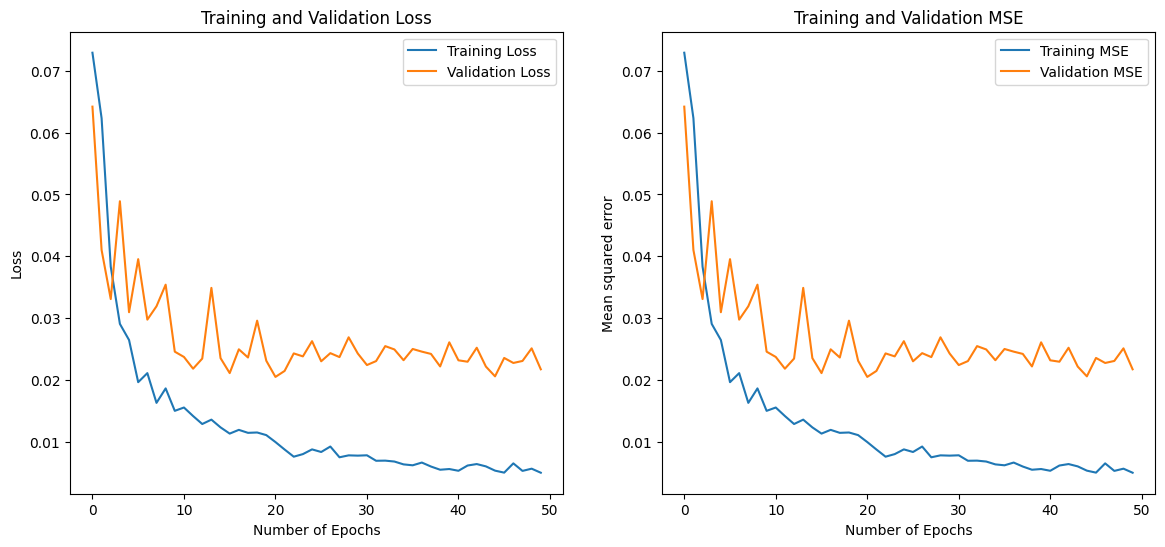

In [144]:
plot_learning_curve(baseline_regression_history)

## LTSM
As they compute the hidden state differently, by deciding what to keep and erase from the memory, they are efficient at capturing long term information

In [145]:
LSTM_model = Sequential(
    name="LSTM_model",
    layers=[
    Embedding(vocab_size,32, input_length=max_length),
    LSTM(64, activation = LeakyReLU(alpha=0.01), dropout=0.3),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(
    optimizer='rmsprop', 
    loss='mean_squared_error', 
    metrics=[MeanSquaredError()])
    
LSTM_model.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 17, 32)            46208     
                                                                 
 lstm_8 (LSTM)               (None, 64)                24832     
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 71,105
Trainable params: 71,105
Non-trainable params: 0
_________________________________________________________________


In [146]:
LSTM_history = LSTM_model.fit(
    X_train,
    y_train, 
    epochs=50, 
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/50
41/41 [==============================] - 3s 44ms/step - loss: 0.0731 - mean_squared_error: 0.0731 - val_loss: 0.0588 - val_mean_squared_error: 0.0588
Epoch 2/50
41/41 [==============================] - 2s 38ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - val_loss: 0.0446 - val_mean_squared_error: 0.0446
Epoch 3/50
41/41 [==============================] - 2s 40ms/step - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0501 - val_mean_squared_error: 0.0501
Epoch 4/50
41/41 [==============================] - 2s 38ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 5/50
41/41 [==============================] - 2s 39ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0275 - val_mean_squared_error: 0.0275
Epoch 6/50
41/41 [==============================] - 2s 39ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 7/50
41/41 [================

In [147]:
LSTM_testscore = evaluate_model(LSTM_model, X_test, y_test)
print(f"Baseline LTSM Test MSE: {LSTM_testscore[0]}")
print(f"Baseline LTSM Test R-squared: {LSTM_testscore[1]}")

14/14 [==============================] - 0s 5ms/step
Baseline LTSM Test MSE: 0.02
Baseline LTSM Test R-squared: 0.71


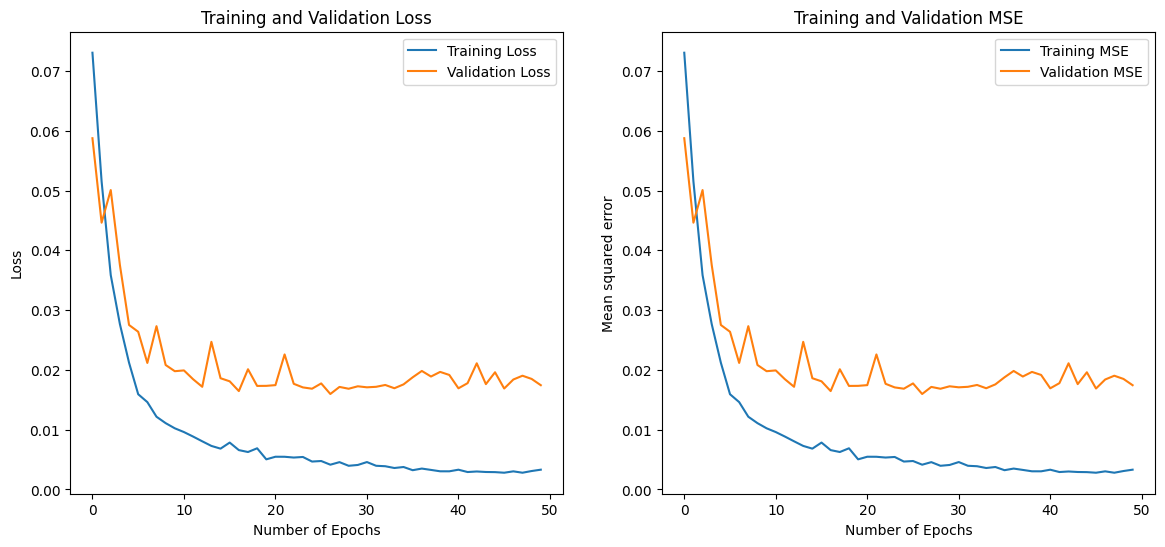

In [148]:
plot_learning_curve(LSTM_history)

## GRU

In [149]:
GRU_model = Sequential(name="GRU_model", layers=[
    Embedding(vocab_size, 32, input_length=max_length),
    GRU(64, activation = LeakyReLU(alpha=0.01), dropout=0.3),
    Dense(1, activation='sigmoid')
])

GRU_model.compile(
    optimizer='rmsprop', 
    loss='mean_squared_error', 
    metrics=[MeanSquaredError()])
    
GRU_model.summary()

Model: "GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 17, 32)            46208     
                                                                 
 gru_3 (GRU)                 (None, 64)                18816     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_________________________________________________________________


In [150]:
GRU_history = GRU_model.fit(
    X_train,
    y_train, 
    epochs=50, 
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/50
41/41 [==============================] - 3s 51ms/step - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0662 - val_mean_squared_error: 0.0662
Epoch 2/50
41/41 [==============================] - 2s 47ms/step - loss: 0.0674 - mean_squared_error: 0.0674 - val_loss: 0.0655 - val_mean_squared_error: 0.0655
Epoch 3/50
41/41 [==============================] - 2s 46ms/step - loss: 0.0658 - mean_squared_error: 0.0658 - val_loss: 0.0577 - val_mean_squared_error: 0.0577
Epoch 4/50
41/41 [==============================] - 2s 45ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 5/50
41/41 [==============================] - 2s 46ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0267 - val_mean_squared_error: 0.0267
Epoch 6/50
41/41 [==============================] - 2s 45ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - val_loss: 0.0273 - val_mean_squared_error: 0.0273
Epoch 7/50
41/41 [================

In [151]:
GRU_testscore = evaluate_model(GRU_model, X_test, y_test)
print(f"Baseline GRU Test MSE: {GRU_testscore[0]}")
print(f"Baseline GRU Test R-squared: {GRU_testscore[1]}")

14/14 [==============================] - 0s 8ms/step
Baseline GRU Test MSE: 0.019
Baseline GRU Test R-squared: 0.72


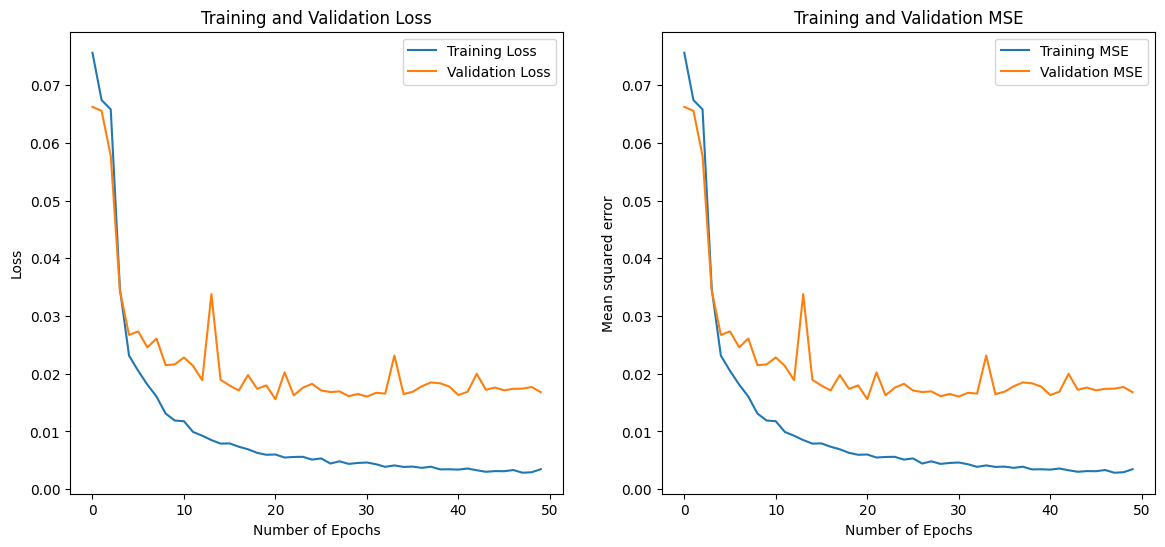

In [152]:
plot_learning_curve(GRU_history)

In [153]:
print("Score comparison:")
pd.DataFrame([baseline_regression_testscore, LSTM_testscore, GRU_testscore], index = ['Baseline', 'LSTM', 'GRU'], columns = ['MSE', 'R-squared'])

Score comparison:


,MSE,R-squared
Baseline,0.021,0.69
LSTM,0.020,0.71
GRU,0.019,0.72


LTSM and GRU produce higher scores than baseline and look promising in terms of training compared to the simpleRNN model

# Model Improvement

## Bidirectional LSTM
Bi-directional LTSM Processes the sequence in both directions (forward pass and backwards pass)

In [ ]:
# Bidirectional LSTM
bidirectional_LSTM_model = Sequential(name="Bidirectional_LSTM_model", layers=[
    Embedding(vocab_size, 32, input_length=max_length),
    Bidirectional(LSTM(128, activation = LeakyReLU(alpha=0.01), dropout=0.3)),
    Dense(1, activation='sigmoid')
])

bidirectional_LSTM_model.compile(
    optimizer='rmsprop', 
    loss='mean_squared_error', 
    metrics=[MeanSquaredError()])

bidirectional_LSTM_model.summary()

Model: "Bidirectional_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 17, 32)            46208     
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 211,329
Trainable params: 211,329
Non-trainable params: 0
_________________________________________________________________


In [123]:
bidirectional_LSTM_history = bidirectional_LSTM_model.fit(
    X_train,
    y_train, 
    epochs=50, 
    verbose=1,
    validation_data=(X_val, y_val)
)

Epoch 1/50
41/41 [==============================] - 6s 82ms/step - loss: 0.0723 - mean_squared_error: 0.0723 - val_loss: 0.0620 - val_mean_squared_error: 0.0620
Epoch 2/50
41/41 [==============================] - 3s 72ms/step - loss: 0.0535 - mean_squared_error: 0.0535 - val_loss: 0.0396 - val_mean_squared_error: 0.0396
Epoch 3/50
41/41 [==============================] - 3s 70ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 4/50
41/41 [==============================] - 3s 69ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 5/50
41/41 [==============================] - 3s 70ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 6/50
41/41 [==============================] - 3s 68ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 7/50
41/41 [================

In [124]:
bidirectional_LSTM_testscore = evaluate_model(bidirectional_LSTM_model, X_test, y_test)
print(f"Bidirectional LSTM Test MSE: {bidirectional_LSTM_testscore[0]}")
print(f"Bidirectional LSTM Test R-squared: {bidirectional_LSTM_testscore[1]}")

14/14 [==============================] - 0s 11ms/step
Bidirectional LSTM Test MSE: 0.019
Bidirectional LSTM Test R-squared: 0.71


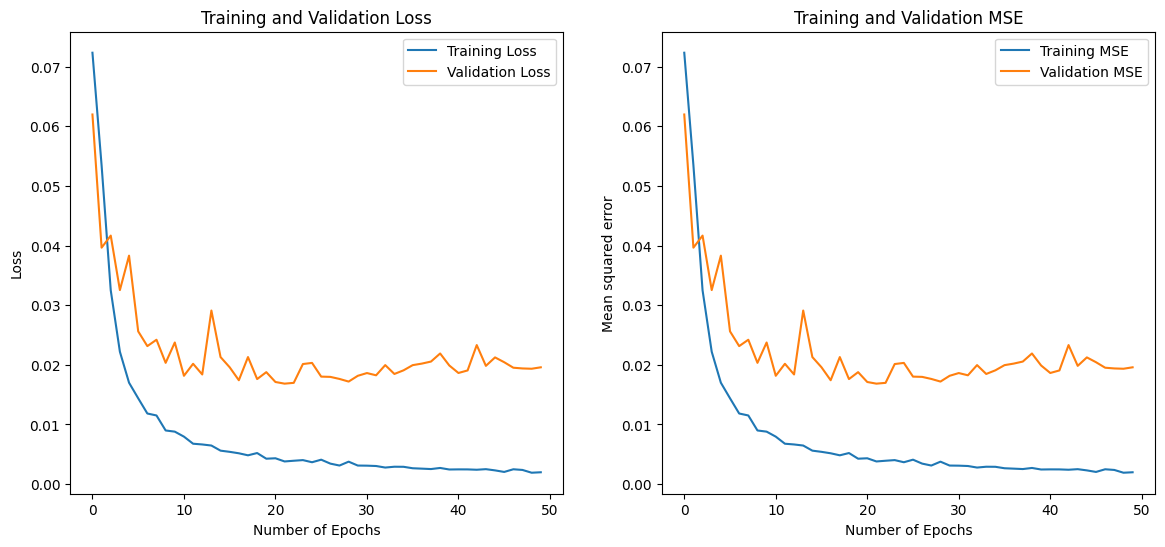

In [125]:
plot_learning_curve(bidirectional_LSTM_history)

In [154]:
print("LSTM vs Bidirectional LSTM comparison:")
pd.DataFrame([LSTM_testscore, bidirectional_LSTM_testscore], index = ['LSTM', 'Bidirectional LSTM'], columns = ['MSE', 'R-squared'])

LSTM vs Bidirectional LSTM comparison:


,MSE,R-squared
LSTM,0.020,0.71
Bidirectional LSTM,0.019,0.71


Bidirectional LTSM gives better results than regular LTSM

In [127]:
bidirectional_LSTM_model.save('Models/bidirectional_LSTM_model.h5')

# Sample prediction

In [ ]:
sample_reviews = ['This move was fantastic! The plot was engaging and the acting was superb.',
                  'I did not like this movie at all. The story was boring and the characters were flat.',
                  'An average movie with some good moments but overall not very memorable.',
                  'The cinematography was stunning, but the plot was weak and predictable.',
                  'A masterpiece of cinema that will be remembered for years to come.']

sample_sequences = tokenizer.texts_to_sequences(sample_reviews)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post')
sample_predictions = bidirectional_LSTM_model.predict(sample_padded)
for review, score in zip(sample_reviews, sample_predictions):
    print(f"Review: {review}\nPredicted Score: {score[0]:.2f}\n")


1/1 [==============================] - 0s 27ms/step
Review: This move was fantastic! The plot was engaging and the acting was superb.
Predicted Score: 0.16

Review: I did not like this movie at all. The story was boring and the characters were flat.
Predicted Score: 0.43

Review: An average movie with some good moments but overall not very memorable.
Predicted Score: 0.60

Review: The cinematography was stunning, but the plot was weak and predictable.
Predicted Score: 0.32

Review: A masterpiece of cinema that will be remembered for years to come.
Predicted Score: 0.06



# Conclusion

- Sentence Splitting, Synonym Replacement and Back-translation are all effective ways to augment the data; they help the models train smoother and gives more data for models to learn from (reduce overfitting)
- Our best model is Bi-directional LTSM
